# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

# Data Loading and cleaning

In [3]:
data=pd.read_csv("twitter_training.csv")
data.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [4]:
#Lets make a checkpoint
df=data.copy()

In [5]:
#Changing the name of cloumns to make more meaningful
df=df.rename(columns={'Positive':'Sentiment','im getting on borderlands and i will murder you all ,':'Tweet'})

In [6]:
#Removing the columns that ww won't need for model training
df=df.drop(['2401','Borderlands'],axis=1)

<AxesSubplot: >

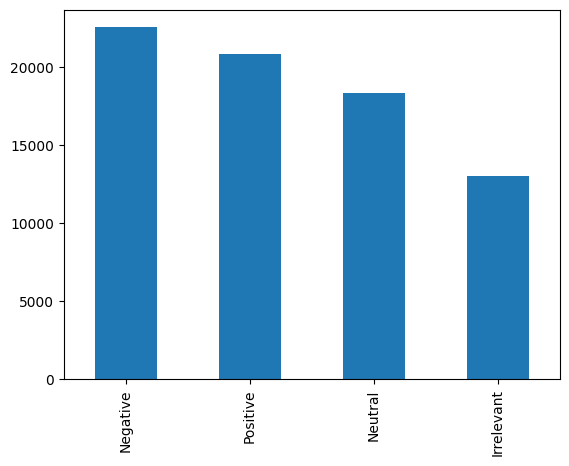

In [7]:
#Checking the balance of data
df['Sentiment'].value_counts().plot(kind='bar')

In [8]:
#We are only interested in Positive, Negative and Normal cases so lets dop Irrelevant
indexes=[]
for i in range(74681):
    if(df['Sentiment'][i]=='Irrelevant'):
        indexes.append(i)

In [9]:
df=df.drop(indexes,axis=0)

In [10]:
#Checking for null values
df.isna().sum()

Sentiment      0
Tweet        571
dtype: int64

In [11]:
#Dropping null values
df=df.dropna()

In [12]:
#Handling categorical nature of our target variable
df['Sentiment']=df['Sentiment'].map({'Positive':2,'Neutral':1,'Negative':0})

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61120 entries, 0 to 74680
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  61120 non-null  int64 
 1   Tweet      61120 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [14]:
#Reset the index
df.reset_index(inplace=True)

# Data Preprocessing

In [15]:
x=df['Tweet']
y=df['Sentiment']

In [16]:
voc_size=10000

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
#Cleaning text data
ps=PorterStemmer()
corpus=[]
for i in range(len(x)):
    rev=re.sub('[^a-zA-Z]',' ',df['Tweet'][i])
    rev=rev.lower()
    rev=rev.split()
    
    rev=[ps.stem(word) for word in rev if not word in stopwords.words('english')]
    rev=' '.join(rev)
    corpus.append(rev)

In [19]:
#One-Hot Encoding
one_hot_rep=[one_hot(words,voc_size) for words in corpus]

In [20]:
#Padding data
sent_length=15
embed=pad_sequences(one_hot_rep,padding='pre',maxlen=sent_length)

In [21]:
#Changing y to categorical type to use categorical_crossentropy loss function
y=to_categorical(y)

In [22]:
#converting data to numpy array
x_array=np.array(embed)
y_array=np.array(y)

In [23]:
#Splitting data as train, test, validation
x_train,x_t,y_train,y_t=train_test_split(x_array,y_array,random_state=42)

In [24]:
x_valid=x_t[:int(x_t.shape[0]*0.35)]
y_valid=y_t[:int(y_t.shape[0]*0.35)]
x_test=x_t[int(x_t.shape[0]*0.35):]
y_test=y_t[int(y_t.shape[0]*0.35):]

# Model Creation and Training

In [25]:
#Model
embed_features=40
model=Sequential()
model.add(Embedding(voc_size,embed_features,input_length=sent_length))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 40)            400000    
                                                                 
 lstm (LSTM)                 (None, 15, 100)           56400     
                                                                 
 dropout (Dropout)           (None, 15, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 486,753
Trainable params: 486,753
Non-trainable params: 0
_________________________________________________________________


In [26]:
early_stopping=EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=1)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                           factor=0.2,
                           pateince=3,
                           verbose=1,
                           min_delta=0.0001)
callbacks_list=[early_stopping,reduce_lr]

In [27]:
h=model.fit(x_train,
          y_train,
          batch_size=64,
          epochs=30,
          verbose=1,
          callbacks=callbacks_list,
          validation_data=(x_valid,y_valid)      
         )

Epoch 1/30
717/717 [==============================] - 20s 24ms/step - loss: 0.7429 - accuracy: 0.6766 - val_loss: 0.6023 - val_accuracy: 0.7580 - lr: 0.0010
Epoch 2/30
717/717 [==============================] - 17s 23ms/step - loss: 0.4888 - accuracy: 0.8091 - val_loss: 0.5273 - val_accuracy: 0.7924 - lr: 0.0010
Epoch 3/30
717/717 [==============================] - 16s 23ms/step - loss: 0.3616 - accuracy: 0.8607 - val_loss: 0.4586 - val_accuracy: 0.8164 - lr: 0.0010
Epoch 4/30
717/717 [==============================] - 16s 23ms/step - loss: 0.2788 - accuracy: 0.8925 - val_loss: 0.4642 - val_accuracy: 0.8368 - lr: 0.0010
Epoch 5/30
717/717 [==============================] - 16s 23ms/step - loss: 0.2240 - accuracy: 0.9122 - val_loss: 0.4394 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 6/30
717/717 [==============================] - 16s 23ms/step - loss: 0.1878 - accuracy: 0.9250 - val_loss: 0.4627 - val_accuracy: 0.8485 - lr: 0.0010
Epoch 7/30
717/717 [==============================] - 16s 

# Results

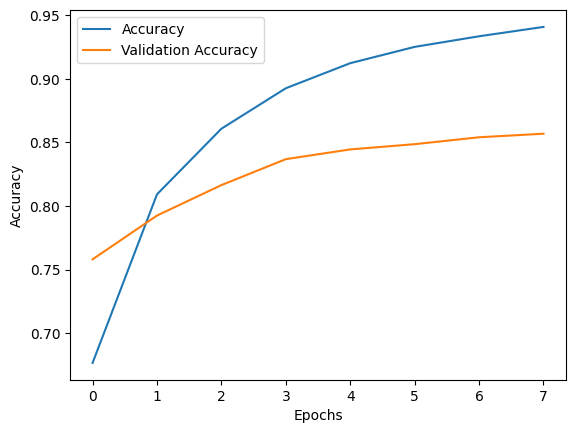

In [28]:
plt.plot(h.history['accuracy'],label='Accuracy')
plt.plot(h.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

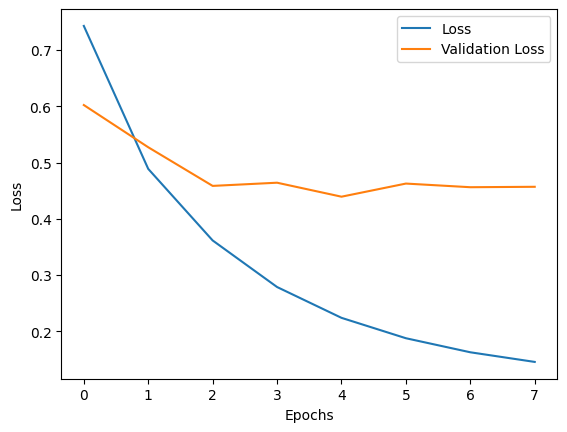

In [29]:
plt.plot(h.history['loss'],label='Loss')
plt.plot(h.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [30]:
#Predictions on test set
preds=model.predict(x_test)
preds_max=np.argmax(preds,axis=1)

311/311 [==============================] - 2s 6ms/step


In [31]:
y_test_values=np.argmax(y_test,axis=1)

<AxesSubplot: >

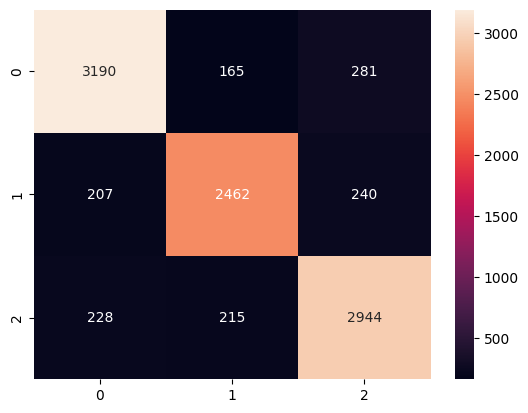

In [32]:
#Confusion Matrix
cm=confusion_matrix(y_test_values,preds_max)
sns.heatmap(cm,annot=True,fmt='d')

In [33]:
#Saving the model
model.save('lstm_model.h5')